# 멋진 작사가 만들기
## 목적
인공지능이 문장을 이해하는 방식과 작문을 가르치는 법 배우기
- 순환신경망(RNN)을 사용해 문장 만들기
- 언어모델(Language Model) 사용
: 일정한 단어 시퀀스가 주어진다면 다음 단어, 그 다음 단어를 계속해서 예측해 낸다.
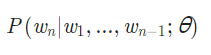

In [1]:
import glob
import os, re 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

## 1. 데이터 다운로드
- 클라우드 환경에 있는 데이터 다운로드

 mkdir -p ~/aiffel/lyricist/models                                           
 ln -s ~/data ~/aiffel/lyricist/data
## 2. 데이터 읽어오기
- glob 모듈을 사용하여 모듈을 파일을 읽어온다.
- glob 모듈을 활용하여 txt파일을 읽어온 후, raw_corpus 리스트에 문장단위로 저장한다

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/AIFFEL_PROJECT/EXPLORATION_4/lyricist/data_1/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])  #앞에서부터 4라인만 화면에 출력

데이터 크기: 187088
Examples:
 ['', '', "Jesus died for somebody's sins but not mine"]


## 3. 데이터 정제
### 토큰화(Tokenize)
텍스트 생성 모델에서 단어사전을 만드는 데 그 기준으로 문장을 일정한 기준으로 쪼개는 과정
- 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용
### 데이터 전처리 과정
- 정규표현식을 이용한 corpus 생성
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
- tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

In [3]:
#전처리를 위해 정규표현식

# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))
    

<start> this is sample sentence . <end>


In [4]:
# 여기에 정제된 문장을 모음
corpus = []

for sentence in raw_corpus:
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(sentence) == 0: continue
    if len(preprocessed_sentence.split()) > 15: continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인
corpus[:10]

['<start> jesus died for somebody s sins but not mine <end>',
 '<start> meltin in a pot of thieves <end>',
 '<start> wild card up my sleeve <end>',
 '<start> thick heart of stone <end>',
 '<start> my sins my own <end>',
 '<start> they belong to me , me <end>',
 '<start> people say beware ! <end>',
 '<start> but i don t care <end>',
 '<start> the words are just <end>',
 '<start> rules and regulations to me , me <end>']

### 벡터화(vectorize)
_tf.keras.preprocessing.text.Tokenizer_ 패키지를 사용해 정제된 데이터를 토큰화하고, 단어사전을 만들어주며 데이터를 숫자로 변환까지 해준다. 이 과정을 _벡터화(vectorize)_ 라 하며, 숫자로 변환된 데이터를 _텐서(tensor)_ 라고 칭한다.

#### 텐서문서참고용 사이트
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
 https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000,  #15000단어를 기억할 수 있는 tokenizer를 만든다
        filters=' ',
        oov_token="<unk>" #15000단어에 포함되지 못한 단어는 "<unk>" 로 변환
    )
# corpus를 이용해 tokenizer 내부의 단어장 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰주기 
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰준다
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)    

[[   2  631  731 ...    0    0    0]
 [   2    1   14 ...    0    0    0]
 [   2  465 1969 ...    0    0    0]
 ...
 [   2   38  905 ...    0    0    0]
 [   2   38   68 ...    0    0    0]
 [   2    8   83 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7ffac98cf890>


In [6]:
print(tensor[:3, :10])

#덴서 데이터는 모두 정수로 이루어져있고, 이 숫자는 tokenizer에 구축된 단어 사전의 인덱스이다.

[[   2  631  731   28  247   17 2250   33   69  238]
 [   2    1   14    9 1968   20 2718    3    0    0]
 [   2  465 1969   29   13 2805    3    0    0    0]]


### tensor에서 소스문장과 타겟문장을 생성

In [7]:
#단어 사전이 어떻게 구축되었는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2  631  731   28  247   17 2250   33   69  238    3    0    0    0]
[ 631  731   28  247   17 2250   33   69  238    3    0    0    0    0]


### tf.data.Dataset객체를 생성

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 4. 인공지능 학습시키기
- tokenize() 함수로 데이터를 Tensor로 변환
- klearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리
- 총 데이터의 20%를 평가 데이터셋으로 사용
- 단어장의 크기는 12,000 이상으로 설정

In [10]:
#훈련 데이터와 평가 데이터를 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,test_size=0.2, random_state=10)

In [11]:
print("Source Train:", np.shape(enc_train))
print("Target Train:", np.shape(dec_train))

Source Train: (124981, 14)
Target Train: (124981, 14)


In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=10)

Epoch 1/10
610/610 [==============================] - 223s 357ms/step - loss: 3.9876
Epoch 2/10
610/610 [==============================] - 222s 364ms/step - loss: 3.0337
Epoch 3/10
610/610 [==============================] - 221s 363ms/step - loss: 2.8517
Epoch 4/10
610/610 [==============================] - 221s 362ms/step - loss: 2.7114
Epoch 5/10
610/610 [==============================] - 220s 361ms/step - loss: 2.5990
Epoch 6/10
610/610 [==============================] - 220s 360ms/step - loss: 2.4925
Epoch 7/10
610/610 [==============================] - 220s 360ms/step - loss: 2.3980
Epoch 8/10
610/610 [==============================] - 219s 359ms/step - loss: 2.3135
Epoch 9/10
610/610 [==============================] - 219s 359ms/step - loss: 2.2362
Epoch 10/10
610/610 [==============================] - 219s 359ms/step - loss: 2.1641


In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3840256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 32,855,961
Trainable params: 32,855,961
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 평가하기
- 모델 loss 확인
- 작문을 시켜보고 직접 평가
- generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행

In [15]:
results = model.evaluate(enc_val, dec_val, verbose=2, batch_size=256)

print('test loss:', results)

123/123 - 16s - loss: 2.0839
test loss: 2.0838570594787598


In [16]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [17]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [18]:
generate_text(model, tokenizer, init_sentence="<start> i hate", max_len=20)

'<start> i hate the way you lie <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> ready to love", max_len=20)

'<start> ready to love you <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> he", max_len=20)

'<start> he s got a <unk> , he s a monster <end> '

In [21]:
generate_text(model, tokenizer, init_sentence="<start> together", max_len=20)

'<start> together , yeah , yeah , yeah <end> '

In [22]:
generate_text(model, tokenizer, init_sentence="<start> break", max_len=20)

'<start> break me off , show me what you got <end> '

## 6.결과
- test loss : 2.0839

자연어처리를 통해 모델을 만드는 것을 처음 접해봐서 그런지 코드해석부터 미니프로젝트에서 어떻게 고쳐나가야할지 막막했다. 스스로 정리를 하면서 공부를 했지만 아직도 너무 어렵게 느껴진다. 
하지만 인공지능 학습모델이 단어나 문장을 입력해줬을 때 문장을 만들어내는 것이 흥미로웠다. 전에 기자라는 직업이 미래에 없어질 직업이라는 기사를 봤었는데, 이번 노드를 진행하면서 정말 이런 일이 머지 않았다는 걸 몸소 느끼기도 했다. 한편 가짜 뉴스를 만들어내는 것을 보면 그것이 가져올 일들이 두렵기도 했다. 가짜뉴스 등의 문제에 앞으로 인공지능이 어떻게 대처해나가야할지 대안이 필요하다고 생각한다. 어쩌면 훈련을 제대로 받지 않아 가짜 뉴스를 퍼트리는 인공지능에 맞서는 새로운 인공지능을 만들어내는 것도 필요할 것 같다는 생각을 하게 되는 시간이었다.